Ce fichier est à executer en entier afin de tester un modèle sur l'environnement.

Pour entrainer un modèle sur cet environnement, il faut exécuter main1.py

Fonction utiles

In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym
from configuration1 import config_dict
import gymnasium as gym
import highway_env
import numpy as np
import torch
#from dqn1 import DQN
from configuration1 import config_dict
from IPython.display import Video, display
import os
import matplotlib.pyplot as plt

from gymnasium import Wrapper

import matplotlib.pyplot as plt




class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.beta = beta_start
        self.frame = 1
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0
    
    def push(self, state, action, reward, terminated, next_state):
        """Sauvegarde une transition avec priorité maximale."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = (state, action, reward, terminated, next_state)



        # Adapter la priorité si le reward est très négatif (ex : collision)
        base_priority = self.max_priority
        if reward < -8:
            base_priority *= 2.0  # léger boost
        self.priorities[self.position] = base_priority



        #self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            return [], [], []
            
        self.beta = min(1.0, self.beta_start + (self.frame / self.beta_frames) * (1.0 - self.beta_start))
        self.frame += 1
        
        if len(self.memory) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]
            
        # Calculer les probabilités d'échantillonnage
        probs = prios ** self.alpha
        probs /= probs.sum()
        
        # Échantillonner avec probabilités
        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]
        
        # Calculer les poids d'importance
        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalisation
        
        return samples, indices, torch.tensor(weights, dtype=torch.float32)
    
    def update_priorities(self, indices, priorities):
        """Mettre à jour les priorités des transitions."""
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio
            self.max_priority = max(self.max_priority, prio)
            
    def __len__(self):
        return len(self.memory)


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, k=batch_size) #pas de remis (test) ? sinon rd.choices

    def __len__(self):
        return len(self.memory)


# class Net(nn.Module):
#     def __init__(self, obs_shape, n_actions):
#         super(Net, self).__init__()
#         c, h, w = obs_shape
#         self.conv = nn.Sequential(
#             nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#         )
#         conv_out_size = self._get_conv_out(obs_shape)
#         self.fc = nn.Sequential(
#             nn.Linear(conv_out_size, 256),
#             nn.ReLU(),
#             nn.Linear(256, n_actions),
#         )

#     def _get_conv_out(self, shape):
#         o = self.conv(torch.zeros(1, *shape))
#         return int(np.prod(o.size()))

#     def forward(self, x):
#         x = x.float()
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)

class Net(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(Net, self).__init__()
        input_size = int(np.prod(obs_shape))  # This ensures proper flattening
        
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x):
        x = x.float()
        batch_size = x.size(0)
        # Aplatir explicitement de [batch_size, 7, 8, 8] à [batch_size, 448]
        x = x.reshape(batch_size, -1)
        return self.net(x)




class DQN:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor  # larger -> more exploration
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """
        
        # Normalize entrée réseau de neurone : state and next_state. ATTENTION CAR PAS AUTOMATIQUE AVEC VALEUR DE CONFIGURATION !
        # state[0, :, :] = state[0, :, :] * 2 - 1
        # state[1:3, :, :] /= 100  # x, y
        # state[3:5, :, :] /= 20   # vx, vy
        # next_state[1:3, :, :] /= 100
        # next_state[3:5, :, :] /= 20

        # state[0, :, :] = state[0, :, :] * 2 - 1
        # state[1:3, :, :] /= 20  # vx, vy
        # next_state[1:3, :, :] /= 20




        # Normalisation progressive des récompenses
        decay_rate = min(1.0, 10.0 / (self.reward_count + 10.0))
        self.reward_mean = (1 - decay_rate) * self.reward_mean + decay_rate * reward
        self.reward_std = max(0.1, (1 - decay_rate) * self.reward_std + decay_rate * abs(reward - self.reward_mean))
        normalized_reward = np.clip((reward - self.reward_mean) / self.reward_std, -5, 5)
        self.reward_count += 1

        # add data to replay buffer
        self.buffer.push(
            torch.tensor(state, dtype=torch.float32).unsqueeze(0),
            torch.tensor([action], dtype=torch.int64),  # plus de double [[]]
            torch.tensor([normalized_reward], dtype=torch.float32),
            torch.tensor([terminated], dtype=torch.int64),
            torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        )


        if len(self.buffer) < self.batch_size:
            return np.inf



        transitions, indices, weights = self.buffer.sample(self.batch_size)
        if len(transitions) == 0:
            return np.inf
        (
            state_batch,
            action_batch,
            reward_batch,
            terminated_batch,
            next_state_batch,
        ) = tuple([torch.cat(data) for data in zip(*transitions)])

        # transitions = self.buffer.sample(self.batch_size)
        # (
        #     state_batch,
        #     action_batch,
        #     reward_batch,
        #     terminated_batch,
        #     next_state_batch,
        # ) = tuple([torch.cat(data) for data in zip(*transitions)])



        values = self.q_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

        
        # Compute the ideal Q values
        with torch.no_grad():
            # next_state_values = (1 - terminated_batch) * self.target_net(
            #     next_state_batch
            # ).max(1)[0]
            # Sélection des actions avec le réseau principal
            next_actions = self.q_net(next_state_batch).argmax(1, keepdim=True)
            # Évaluation avec le réseau cible
            next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch).gather(1, next_actions).squeeze(1)

            targets = next_state_values * self.gamma + reward_batch

        td_errors = (values - targets).detach()
        loss = F.smooth_l1_loss(values, targets, reduction='none')
        loss = (weights.to(td_errors.device) * loss).mean()

        #loss = self.loss_function(values, targets)




        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()

        # # Mise à jour des priorités
        new_priorities = td_errors.abs().clamp(0, 10).detach().cpu().numpy() + 1e-6
        self.buffer.update_priorities(indices, new_priorities)


        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), max_norm=5)
        # torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.item()
    
    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        # normalized_state = state.copy()
        # state[0, :, :] = state[0, :, :] * 2 - 1
        # # state[1:3, :, :] /= 100  # x, y
        # # state[3:5, :, :] /= 20   # vx, vy

        # state[1:3, :, :] /= 20 #vx, vy



        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)
    

    def get_action(self, env, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        # state = state.copy()
        # # Normalize entrée réseau de neurone : state and next_state. ATTENTION CAR PAS AUTOMATIQUE AVEC VALEUR DE CONFIGURATION !
        # # state[1:3, :, :] /= 100  # x, y
        # # state[3:5, :, :] /= 20   # vx, vy
        
        # state[1:3, :, :] /= 20  # vx, vy

        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

    def decrease_epsilon(self):
        # self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
        #     np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        # )
        self.epsilon = max(self.epsilon_min, self.epsilon_start - (self.n_eps / self.decrease_epsilon_factor))



    def reset(self):

        #obs_size = self.observation_space.shape[0] #1D
        obs_shape = self.observation_space.shape
        n_actions = self.action_space.n

        self.q_net = Net(obs_shape, n_actions)
        self.target_net = Net(obs_shape, n_actions)


        self.buffer = PrioritizedReplayBuffer(self.buffer_capacity)
        #self.buffer = ReplayBuffer(self.buffer_capacity)

        self.loss_function = nn.SmoothL1Loss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate
        )

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0



class CustomRewardWrapper(Wrapper):
    def __init__(self, env, config):
        super().__init__(env)
        self.config = config

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)

        base_env = self.env.unwrapped  # accès direct à l'env highway pur

        reward = 0.0

        # Collision
        if base_env.vehicle.crashed:
            reward += self.config["collision_reward"]

        # Staying on the right lane
        right_lane_factor = 1 - int(base_env.vehicle.lane_index[1]) / max(self.config["lanes_count"]-1, 1)
        reward += self.config["right_lane_reward"] * right_lane_factor

        # High speed
        v = np.linalg.norm(base_env.vehicle.velocity)
        v_min, v_max = self.config["reward_speed_range"]
        speed_factor = np.clip((v - v_min) / (v_max - v_min), 0, 1)
        reward += self.config["high_speed_reward"] * speed_factor

        # Lane change penalty
        if action != base_env.vehicle.action['steering']:
            reward += self.config["lane_change_reward"]

        return obs, reward, terminated, truncated, info


Run one episode

In [3]:
import gymnasium as gym
import highway_env
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from configuration1 import config_dict

%matplotlib inline



# Création de l'environnement
env = gym.make('highway-v0', render_mode="rgb_array")
env.unwrapped.configure(config_dict)
# On Wrappe l'environnement pour redéfinir la récompense	
env = CustomRewardWrapper(env, config_dict)
env.reset()

# Afficher les états et actions possibles
print("Observation Space:", env.observation_space)
print(env.unwrapped.config["collision_reward"])
print(env.unwrapped.config["high_speed_reward"])
print(env.unwrapped.config["right_lane_reward"])


# Définition des paramètres du DQN (les mêmes que pour l'entraînement)
agent = DQN(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    batch_size=64,
    buffer_capacity=150000,
    update_target_every=100,
    epsilon_start=1.0,
    decrease_epsilon_factor=2000,  # decrease agressif
    epsilon_min=0.1,
    learning_rate=2e-4,
)

# Charger le modèle et les poids
agent.q_net.load_state_dict(torch.load("dqn_q_net2.pth"))



def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)  # On clone pour ne pas toucher au vrai env
    done = False
    state, _ = display_env.reset()

    state[0, :, :] = state[0, :, :] * 2 - 1
    state[1:3, :, :] /= 100  # x, y
    state[3:5, :, :] /= 20  # vx, vy


    rewards = 0
    agent.epsilon = 0  # L'agent exploite uniquement (pas d'exploration)

    while not done:
        action = agent.get_action(env, state)
        state, reward, terminated, truncated, _ = display_env.step(action)

        state[0, :, :] = state[0, :, :] * 2 - 1
        state[1:3, :, :] /= 100  # x, y
        state[3:5, :, :] /= 20  # vx, vy


        #print(f"Rewards : {rewards}")
        done = terminated or truncated
        rewards += reward
        
        if display:
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.axis('off')
            plt.show()
    
    if display:
        display_env.close()

    print(f"Reward total de l'épisode : {rewards}")

# Lancer une visualisation de ton agent DQN :
run_one_episode(env, agent, display=True)


Observation Space: Box(-inf, inf, (7, 8, 8), float32)
-16
0.9
0.05


RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for net.0.weight: copying a param with shape torch.Size([512, 189]) from checkpoint, the shape in current model is torch.Size([512, 448]).

Vision agent

In [6]:
state, _ = env.reset()


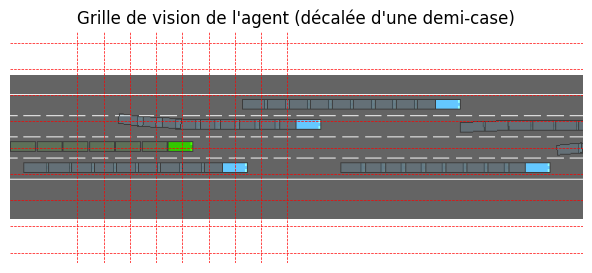

Agent's Observation (State):
(7, 8, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenir la perception de l'agent sans prendre d'action
state, reward, terminated, truncated, _ = env.step(action=None)

# Rendu de l'image
frame = env.render()

# Paramètres de la grille (avec décalage de 0.5 case vers la gauche)
grid_x = np.arange(-20, 20 + 0.1, 5)
grid_y = np.arange(-20, 20 + 1, 5)

# Convertir les coordonnées en pixels
scaling = env.config["scaling"]
center_x = env.config["screen_width"] * env.config["centering_position"][0]
center_y = env.config["screen_height"] * env.config["centering_position"][1]

# Affichage image + grille
plt.figure(figsize=(12, 3))
plt.imshow(frame)
for gx in grid_x:
    x = center_x + gx * scaling
    plt.axvline(x, color='red', linestyle='--', linewidth=0.5)
for gy in grid_y:
    y = center_y - gy * scaling
    plt.axhline(y, color='red', linestyle='--', linewidth=0.5)

plt.title("Grille de vision de l'agent (décalée d'une demi-case)")
plt.axis('off')
plt.show()


# Affichage console de l'observation
print("Agent's Observation (State):")
print(state.shape)
print(state[0, :, :])  # Affiche la couche "presence" uniquement



# A FAIRE

- Prioritized Experience Replay
- Réseau un peu plus profond
- Entrainement > 2000 epoch

# REGARDER EFFET
- Normalisation entrée
- Plus d'observation